# SPLAT Demonstration

Spatial Pathway Level Analysis Tool (SPLAT) is a computational method for quantifying the overall expression levels of gene sets/pathways for spatial transcriptomics data.

SPLAT returns a pathway activity score (PAS) for each spot.

### Step 0: Import the splat package.

In [2]:
from pathlib import Path
import pandas as pd
import sys

project_directory = Path("__notebook__").resolve().parent.parent
sys.path.append(str(project_directory))

from splat import SPLAT

### Step 1: Load the data.

In this demo, we'll analyze the 10x Visium BRCA dataset. Let's first load and inspect the gene expression count data. The gene expression dataframe should be of dimension $N \times G$, where $N$ denotes the number of spots, and $G$ denotes the number of genes.

In [3]:
expression_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-count_data.pkl"
).T
display(expression_df.head())

gene,DVL1,PIK3CD,MTOR,CASP9,WNT4,E2F2,HDAC1,CSF3R,SLC2A1,PTCH2,...,TLR8,VEGFD,ARAF,AR,IL2RG,FGF16,COL4A6,XIAP,FGF13,IKBKG
barcode,,,,,,,,,,,,,,,,,,,,,
GTAGACAACCGATGAA-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
ACAGATTAGGTTAGTG-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
TGGTATCGGTCTGTAT-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ATTATCTCGACAGATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
TGAGATCAAATACTCA-1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Next, let's load and inspect the spatial location data. The location data is of dimension $N \times 2$.
Note: the index of the location dataframe must match the columns of the expression dataframe.

In [4]:
location_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-location_data.pkl"
)
display(location_df.head())

# note: SPLAT requires spatial locations to be in the form of a DataFrame containing columns "x" and "y"
location_df = location_df.rename(columns={"array_row": "x", "array_col": "y"})
display(location_df.head())

,array_row,array_col
barcode,,
GTAGACAACCGATGAA-1,7,55
ACAGATTAGGTTAGTG-1,7,57
TGGTATCGGTCTGTAT-1,7,59
ATTATCTCGACAGATC-1,7,61
TGAGATCAAATACTCA-1,7,63


,x,y
barcode,,
GTAGACAACCGATGAA-1,7,55
ACAGATTAGGTTAGTG-1,7,57
TGGTATCGGTCTGTAT-1,7,59
ATTATCTCGACAGATC-1,7,61
TGAGATCAAATACTCA-1,7,63


Finally, let's load the pathway data. Pathway data may be stored as a $G \times n_\text{pathways}$ binary matrix.

In [5]:
pathways_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-pathways_data.pkl"
)
display(pathways_df.head())

# we can also work with pathways as dictionaries mapping pathway name to list of genes
pathways_dict = {
    pathway: list(pathways_df.index[pathways_df[pathway] == 1])
    for pathway in pathways_df.columns
}
print(pathways_dict)

,KEGG_PATHWAYS_IN_CANCER,WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT
SAMD11,0,0
NOC2L,0,0
KLHL17,0,0
PLEKHN1,0,0
PERM1,0,0


{'KEGG_PATHWAYS_IN_CANCER': ['DVL1', 'PIK3CD', 'MTOR', 'CASP9', 'WNT4', 'E2F2', 'HDAC1', 'CSF3R', 'SLC2A1', 'PTCH2', 'PIK3R3', 'JUN', 'JAK1', 'WNT2B', 'NRAS', 'PIAS3', 'ARNT', 'NTRK1', 'RXRG', 'FASLG', 'LAMC1', 'LAMC2', 'TPR', 'PTGS2', 'RASSF5', 'LAMB3', 'TRAF5', 'TGFB2', 'WNT9A', 'WNT3A', 'EGLN1', 'FH', 'AKT3', 'SOS1', 'EPAS1', 'MSH2', 'MSH6', 'TGFA', 'CTNNA2', 'TCF7L1', 'PAX8', 'RALB', 'GLI2', 'ITGA6', 'ITGAV', 'STAT1', 'CASP8', 'FZD7', 'FZD5', 'FN1', 'STK36', 'WNT6', 'WNT10A', 'COL4A4', 'VHL', 'PPARG', 'RAF1', 'WNT7A', 'RARB', 'TGFBR2', 'MLH1', 'CTNNB1', 'LAMB2', 'RHOA', 'RASSF1', 'WNT5A', 'APPL1', 'MITF', 'TFG', 'CBLB', 'GSK3B', 'PIK3CB', 'MECOM', 'PLD1', 'PIK3CA', 'DVL3', 'FGF12', 'CTBP1', 'FGFR3', 'PDGFRA', 'KIT', 'CXCL8', 'FGF5', 'MAPK10', 'NFKB1', 'LEF1', 'EGF', 'FGF2', 'HHIP', 'VEGFC', 'CASP3', 'SKP2', 'FGF10', 'ITGA2', 'PIK3R1', 'MSH3', 'APC', 'TCF7', 'WNT8A', 'CTNNA1', 'FGF1', 'CSF1R', 'PDGFRB', 'FGF18', 'MAPK9', 'E2F3', 'RXRB', 'PPARD', 'CDKN1A', 'VEGFA', 'HSP90AB1', 'LAMA4

### Step 2: Use SPLAT to compute pathway activity scores

This is the simplest use case for SPLAT. Simply inpute the data and generate an 
activity scores report.

SPLAT (info): Removed 17609 genes not found in expression data. 334 genes remain. 
SPLAT (info): Identified 334 common genes in the pathway and expression data. 
SPLAT (info): Identified 2518 common spots in the location and expression data. 
SPLAT (info): Normalized expression data with strategy 'normalize-log1p'. 
SPLAT (info): Model initialization complete. 
SPLAT (info): Beginning activity score computation for 2 pathways with 2 jobs. Method 
               used: cpu. 
SPLAT (info): (Job 2: 
               WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT) 
               Activity score computation for 
               WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT 
               completed in 0.63 seconds. 
SPLAT (info): (Job 1: KEGG_PATHWAYS_IN_CANCER) Activity score computation for 
               KEGG_PATHWAYS_IN_CANCER completed in 2.4 seconds. 


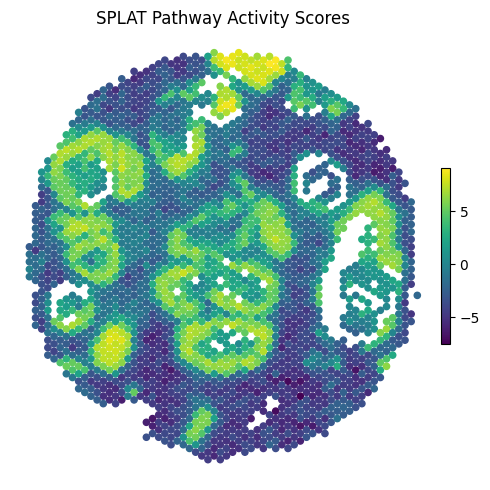

In [7]:
splat_model = SPLAT(
    expression_df=expression_df,
    location_df=location_df,
    pathways_df=pathways_df,
    k=6,  # increase k to increase spatial smoothing effect
    normalize_counts_method="normalize-log1p",  # easily normalize counts for non-preprocessed data!
)
# compute activity scores for all pathways in pathways_df
splat_report = splat_model.generate_pas_report(
    beta=0.33,  # increase beta to increase spatial smoothing strength; must be between 0 and 1
    compute_method="cpu",  # use "gpu" for GPU acceleration if available
)
# quickly plot spatial map of activity scores for a specific pathway
figure = splat_report.plot_pas_spatial_map(
    pathway="KEGG_PATHWAYS_IN_CANCER",  # specify the pathway of interest
    size=20,  # dot size
    cmap="viridis",
    figsize=(5, 5),
)  # returns a matplotlib Figure object
display(figure)

You can easily retrieve relevant data in `pd.DataFrame` form from the SPLAT activity scores report.

In [8]:
display(splat_report.pas_df())
display(splat_report.metagene_df(pathway="KEGG_PATHWAYS_IN_CANCER"))

,KEGG_PATHWAYS_IN_CANCER,WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT
barcode,,
GTATCTCAGTCTTGAC-1,-2.903961,-0.456785
GCCTCCGACAATTCAC-1,-4.287374,-0.497681
ATTCAGGACCTATTTC-1,-1.982516,0.145658
GACTAAGATCATGCAC-1,-3.511847,1.515388
CTGGACGCAGTCCGGC-1,-4.310693,0.707594
...,...,...
AGTACGGGCACCTGGC-1,6.281004,-1.726130
CCCAGTAAACTTGGGA-1,-3.119829,-0.069125
TTAGAGTTTAGAAGGA-1,-2.716687,1.711178


,KEGG_PATHWAYS_IN_CANCER
ERBB2,0.209567
RARA,0.174562
PRKCA,0.174359
CDH1,0.168846
VEGFA,0.157969
...,...
GSTP1,-0.127471
PDGFRB,-0.139553
CSF1R,-0.144342
FOS,-0.167230


You can also work directly with pathways in dictionary form.

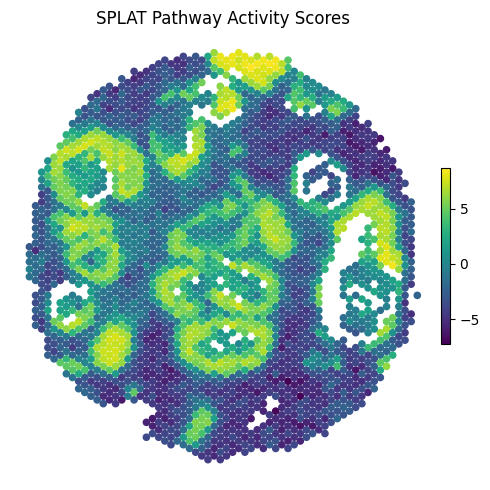

In [7]:
splat_model_no_pathways_df = SPLAT(
    expression_df=expression_df,
    location_df=location_df,
    k=6,
    normalize_counts_method="normalize-log1p",
    verbose=False,  # set verbose to False to suppress console output
)
splat_report = splat_model_no_pathways_df.generate_pas_report(
    pathways_dict=pathways_dict, beta=0.33, compute_method="cpu"
)
splat_report.plot_activity_scores(
    pathway="KEGG_PATHWAYS_IN_CANCER", size=20, cmap="viridis", figsize=(5, 5)
)

### Step 3: Use SPLAT to systematically identify spots with significantly elevated pathway activity

In [8]:
splat_model = SPLAT(
    expression_df=expression_df,
    location_df=location_df,
    pathways_df=pathways_df,
    k=6,
    normalize_counts_method="normalize-log1p",
)
splat_model.identify_spots_with_elevated_pas(
    pathway="KEGG_PATHWAYS_IN_CANCER", control_size=100, n_jobs=4  # set number of CPUs
)

SPLAT (info): Identified 17943 common genes in the pathway and expression data. 
SPLAT (info): Identified 2518 common spots in the location and expression data. 
SPLAT (info): Normalized expression data with strategy 'normalize-log1p'. 
SPLAT (info): Model initialization complete. 
SPLAT (info): Beginning activity score computation for 101 pathways with 4 jobs. Method 
               used: cpu. 
SPLAT (info): (Job 3: CONTROL-1) Activity score computation for CONTROL-1 completed in 
               3.08 seconds. 
SPLAT (info): (Job 2: CONTROL-0) Activity score computation for CONTROL-0 completed in 
               3.09 seconds. 
SPLAT (info): (Job 1: KEGG_PATHWAYS_IN_CANCER) Activity score computation for 
               KEGG_PATHWAYS_IN_CANCER completed in 3.14 seconds. 
SPLAT (info): (Job 4: CONTROL-2) Activity score computation for CONTROL-2 completed in 
               3.14 seconds. 
SPLAT (info): (Job 6: CONTROL-4) Activity score computation for CONTROL-4 completed in 
             

,x,y,pas,p
barcode,,,,
CAGATACTAACATAGT-1,26,46,-1.363100,0.37
GAGGCTATCAAAGTCG-1,35,27,-2.458995,0.89
TACGACTGCCTCTTAG-1,44,66,0.845502,0.84
ATGCTCAGTGTTGCAT-1,21,29,1.384740,0.06
TCGGGAACGTGCCTAG-1,31,109,-4.359853,0.99
...,...,...,...,...
GCCTATTTGCTACACA-1,8,50,-3.250701,0.92
CATCGGACGGGTTAAT-1,42,58,6.576455,0.02
GCACGCCTACTTAGAT-1,55,39,1.503992,0.08
